# Notebook for tickers data processing

- use a list of tickers to process from a text file tickers.txt ; the content of this text file is a list of tickers, one per line, obtained with finviz.com screener (see readme.md for more details),
- read the tickers data (date+closing) from the yahoo finance python API,
- save the tickers data to pickle files (one per ticker) for a quicker access,
- create a graph for each ticker with the closing price over time, SMA20, SMA50, SMA200 and save it to a png file (one per ticker),
- analyse each graph and keep only the tickers that are interesting for further analysis :
    - price up for one year,
    - SMA20 up for one year,
    - SMA50 up for one year,
    - SMA200 up for one year,
    - min_price <= last price <= max_price.
- display a graph for the kept tickers with the closing price over time, SMA20, SMA50, SMA200 and annualized historical volatility.

In [19]:
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd

## Parameters

In [20]:
# historical data range
historical_range_start = '2021-01-03'
historical_range_end='2023-10-26'

# price limits to keep ticker
max_price = 100
min_price = 0

## Constants

In [21]:
# file parameters
ticker_file = 'params/tickers.txt'
data_path = 'data/'
image_path = 'images/'
pkl_ext = '.pkl'
png_ext = '.png'

# number of days to consider for the moving average
index_12m = -252
index_6m = -128
index_3m = -66
index_1m = -23
index_now = -1


# Get the list of tickers to process from the file tickers.txt


In [22]:
tickers_list = np.loadtxt(ticker_file, dtype=str)
print(len(tickers_list), 'tickers in list.')
print(tickers_list[:4], '...', tickers_list[-4:])

563 tickers in list.
['A' 'AAPL' 'ABBV' 'ABEV'] ... ['YUMC' 'ZBH' 'ZTO' 'ZTS']


# Read the historical data for the tickers from the file tickers.txt 
- save in pickle format

Update the historical_range_start and historical_range_end dates then run this cell.

Information: it takes several minutes (approx. 6') to get all data from yahoo finance.

In [ ]:
for ticker in tickers_list:
    tk = yf.Ticker(ticker)
    data = tk.history(
        interval='1d', start=historical_range_start, end=historical_range_end)
    data.head()
    filename = data_path+ticker+pkl_ext
    data.to_pickle(filename)
    print('Saved', filename)


# Load the historical data for the tickers from the files
- read from pickle format

In [ ]:
data = {}
for ticker in tickers_list:
    filename = data_path+ticker+pkl_ext
    d = pd.read_pickle(filename)
    print('Read', filename)
    data[ticker]=d
    

# Graph all tickers and save as PNG image

- closing price
- SMA20,
- SMA50,
- SMA200.

Information: it takes several minutes (approx. 3') to save all figures.

In [ ]:
for ticker in tickers_list:
    info = data[ticker]

    sma20 = info['Close'].rolling(window=20).mean()
    sma50 = info['Close'].rolling(window=50).mean()
    sma200 = info['Close'].rolling(window=200).mean()
    fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(info['Close'], 'k', label='Close' )
    plt.plot(sma20, 'g', label='SMA20')
    plt.plot(sma50, 'b', label='SMA50')
    plt.plot(sma200, 'r', label='SMA200')
    plt.title('Close price of '+ticker)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    img_filename = image_path+ticker+png_ext
    plt.savefig(img_filename)
    print('save figure', img_filename)
    plt.close()


## function to check select the ticker of not 

Conditions are :
- closing price at index2 > closing price at index 1,
- SMA20 at index2 > SMA20 at index 1,
- SMA50 at index2 > SMA50 at index 1,
- SMA200 at index2 > SMA200 at index 1.

returns False or True.

In [ ]:
def is_ticker_up(info,index1,index2):
    sma20 = info['Close'].rolling(window=20).mean()
    sma50 = info['Close'].rolling(window=50).mean()
    sma200 = info['Close'].rolling(window=200).mean()

    close_up = True if info['Close'][index1] < info['Close'][index2] else False
    sma20_up = True if sma20[index1] < sma20[index2] else False
    sma50_up = True if sma50[index1] < sma50[index2] else False
    sma200_up = True if sma200[index1] < sma200[index2] else False

    return close_up and sma20_up and sma50_up and sma200_up


# test with AAPL
info = data['AAPL']
print('is_ticker_up 12 month', is_ticker_up(info,index_12m,index_now))
print('is_ticker_up 6 month', is_ticker_up(info, index_6m, index_now))
print('is_ticker_up 3 month', is_ticker_up(info, index_3m, index_now))
print('is_ticker_up 1 month', is_ticker_up(info,index_1m,index_now))

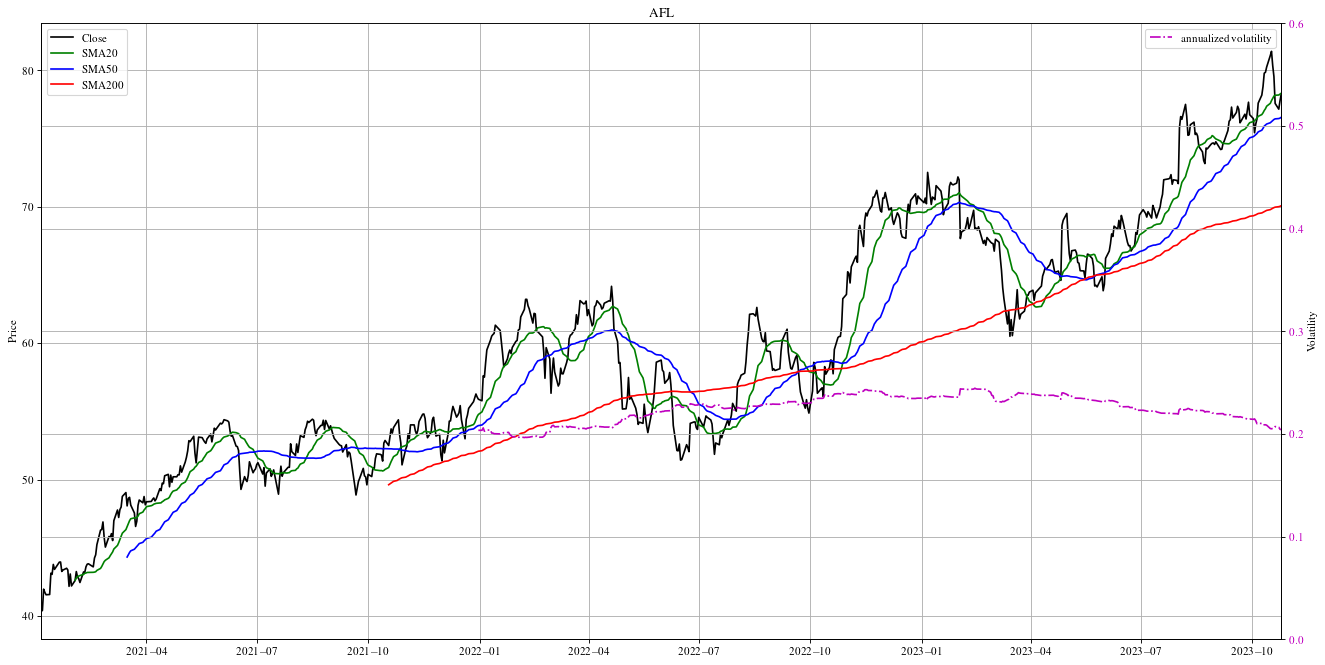

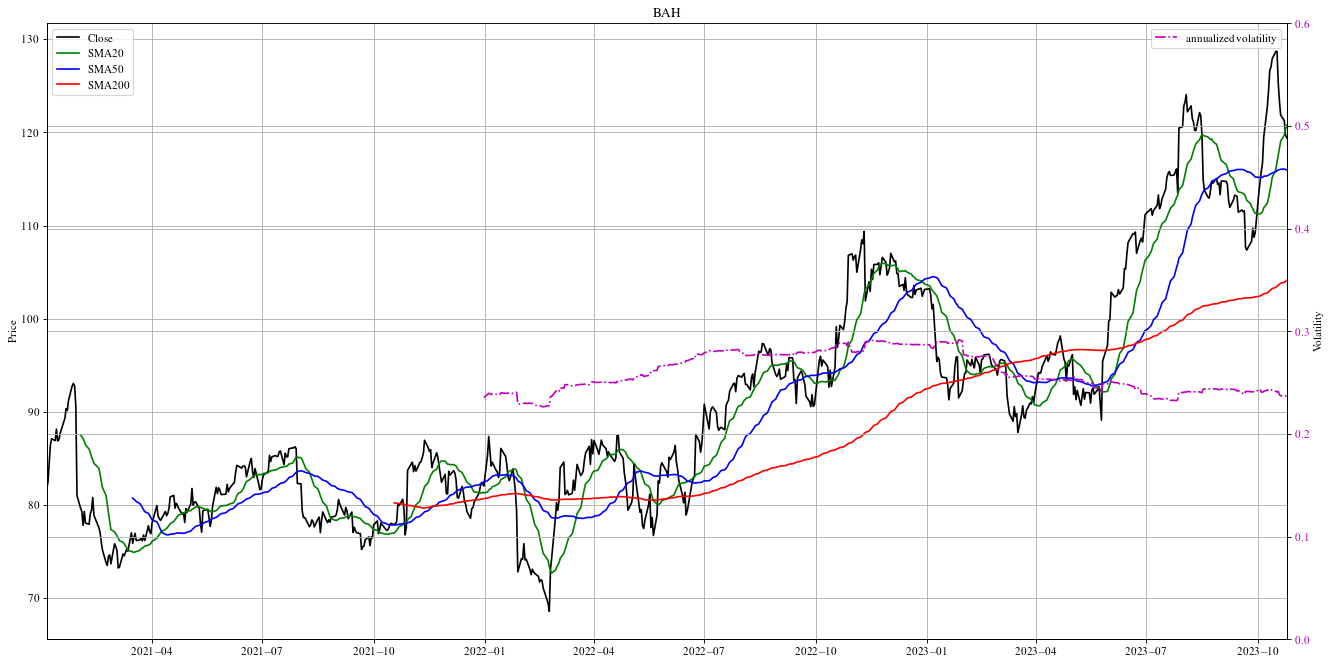

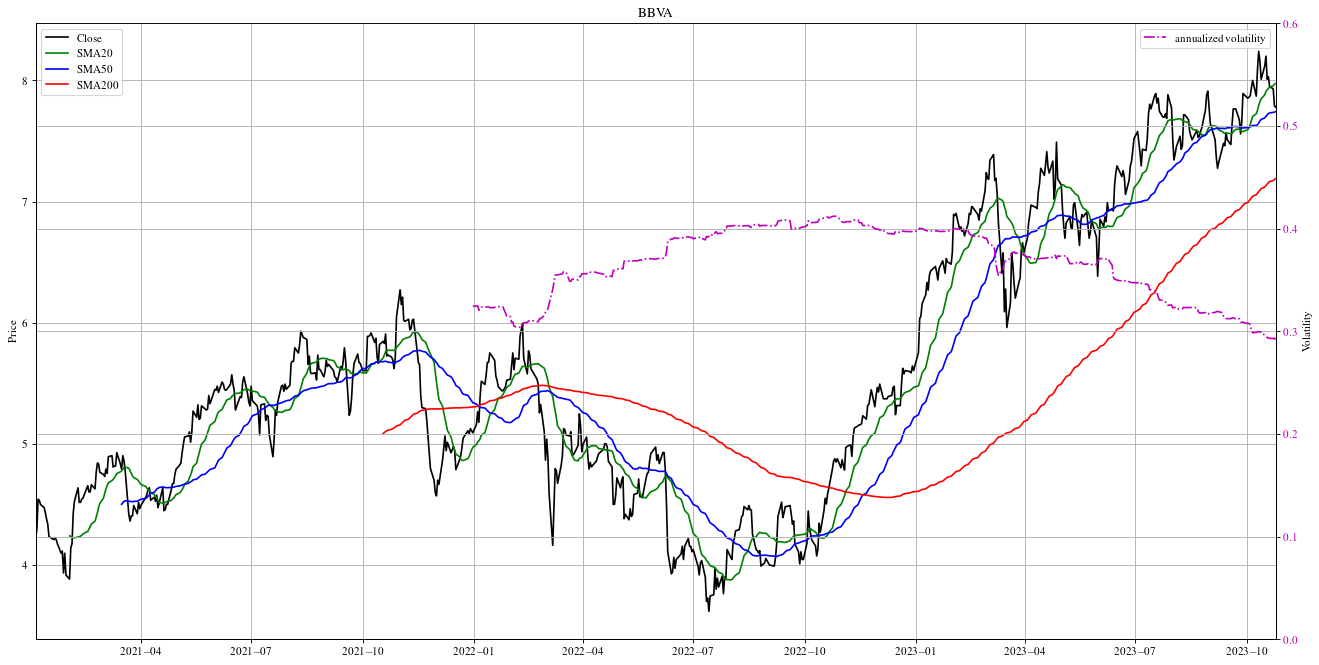

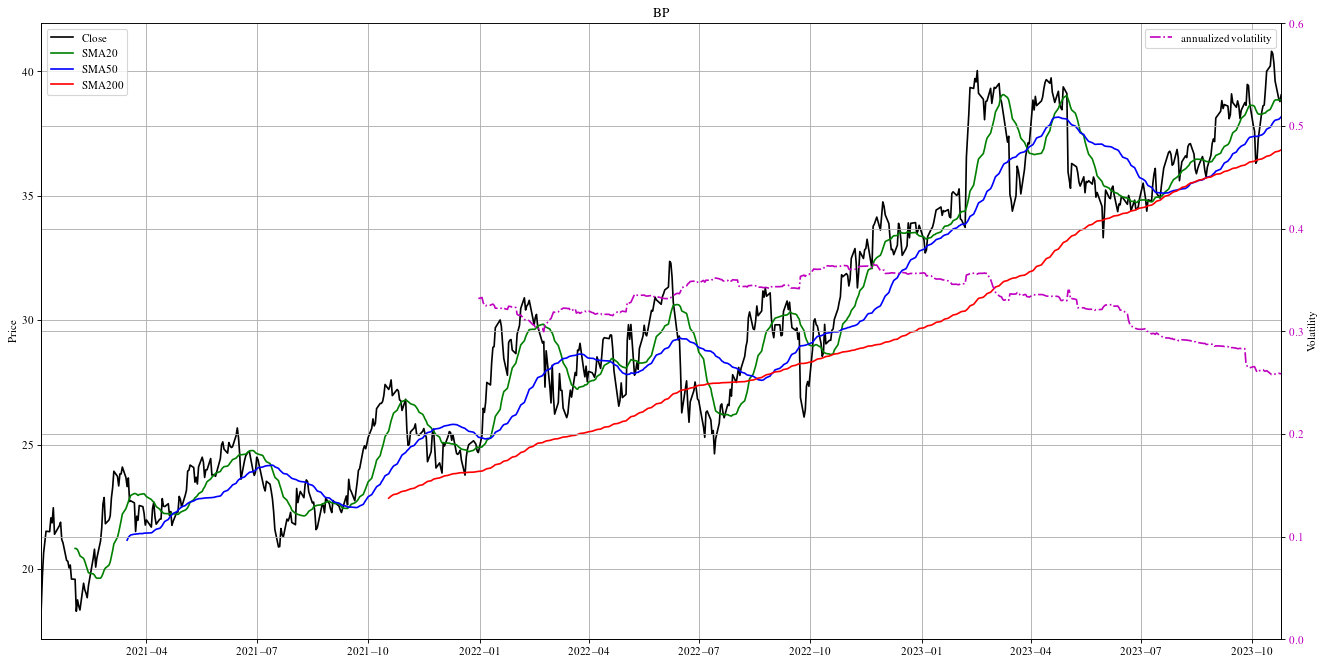

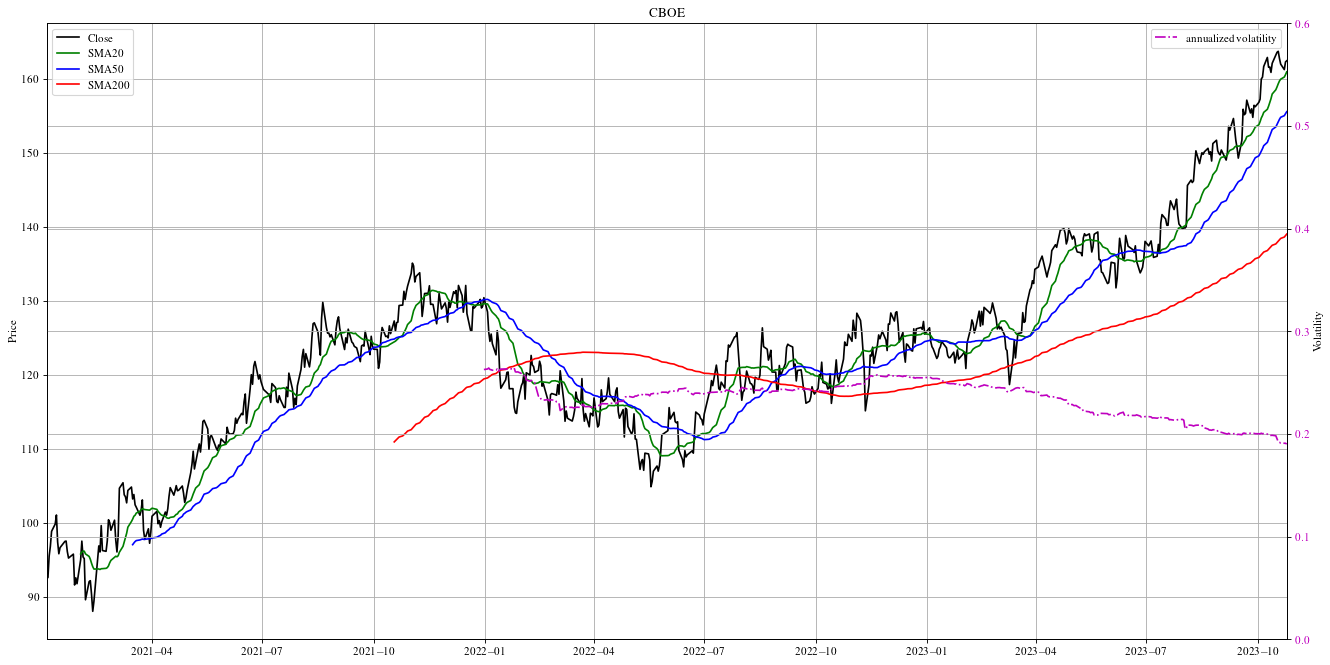

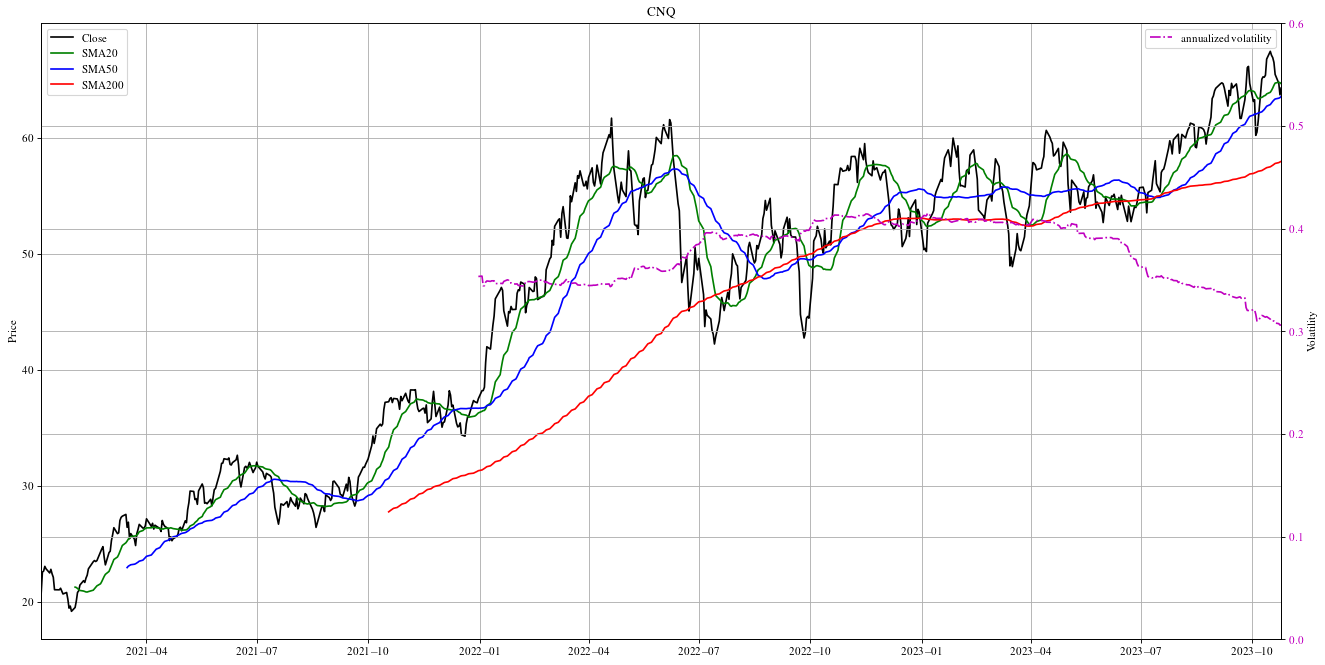

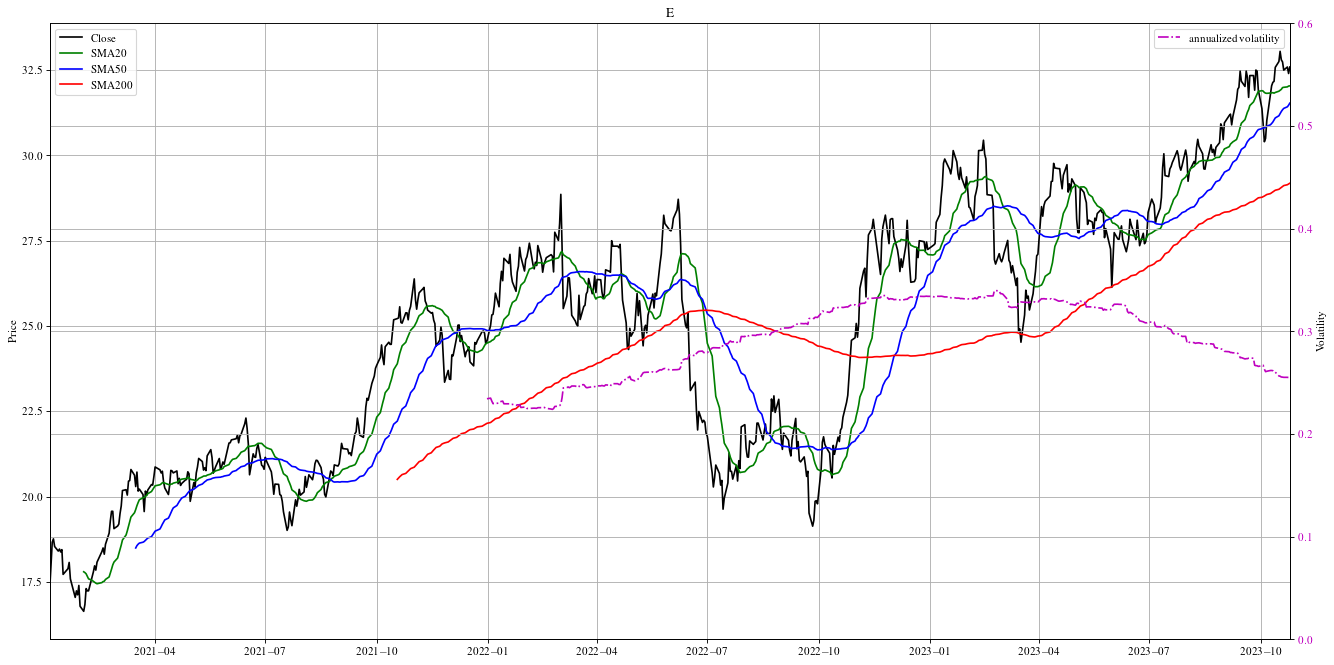

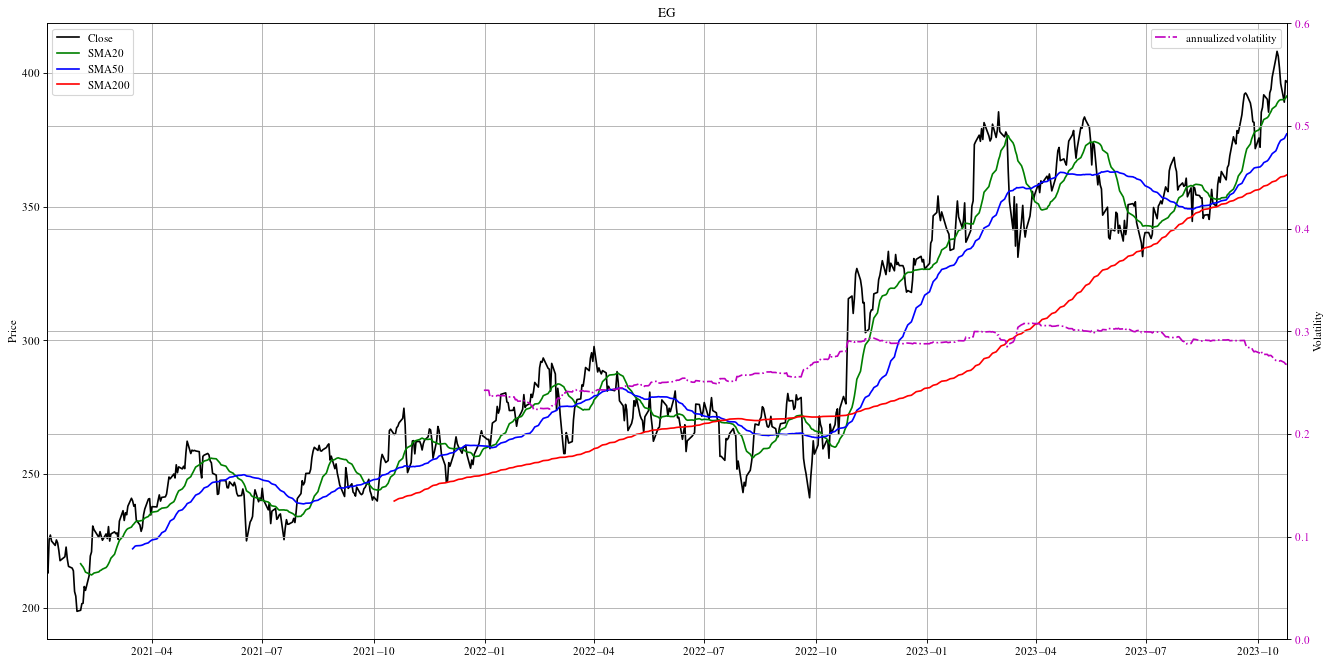

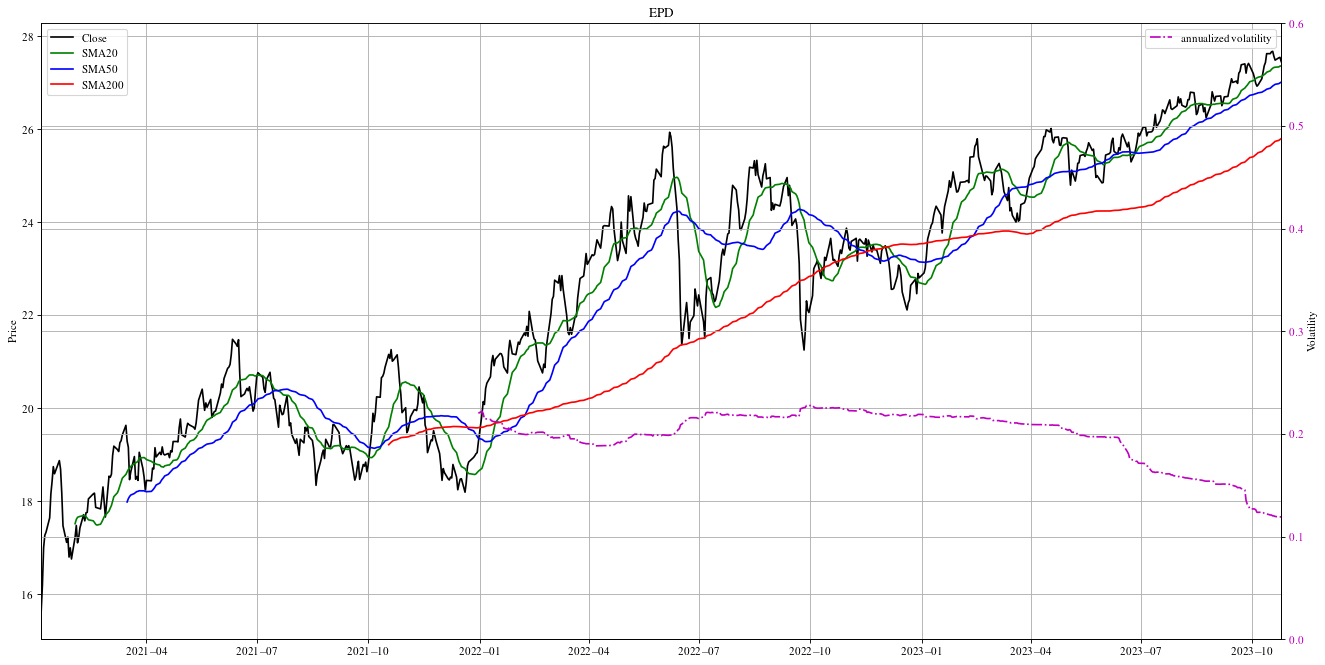

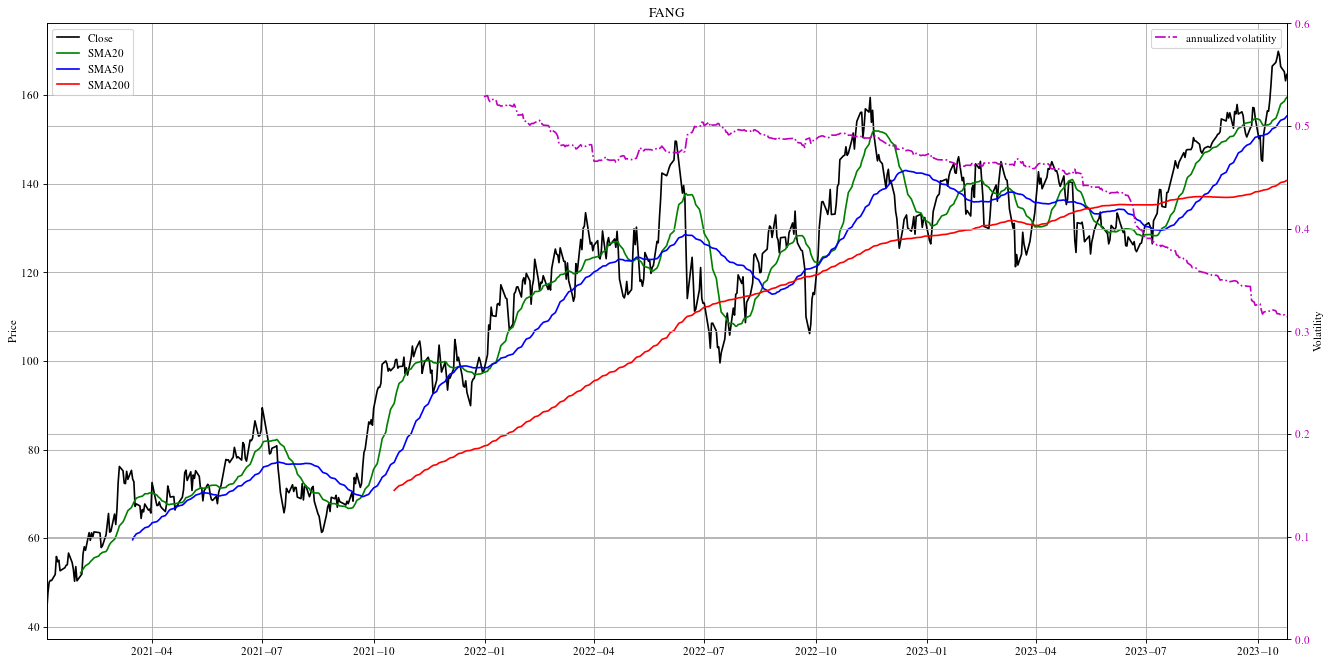

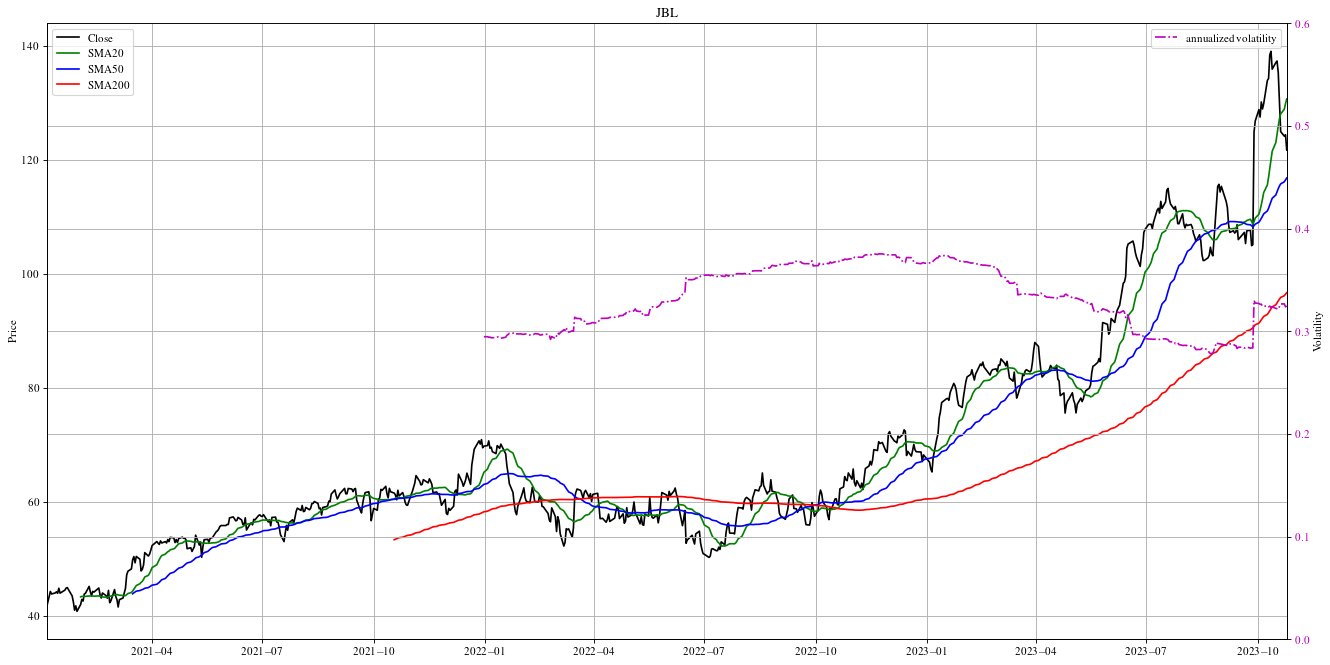

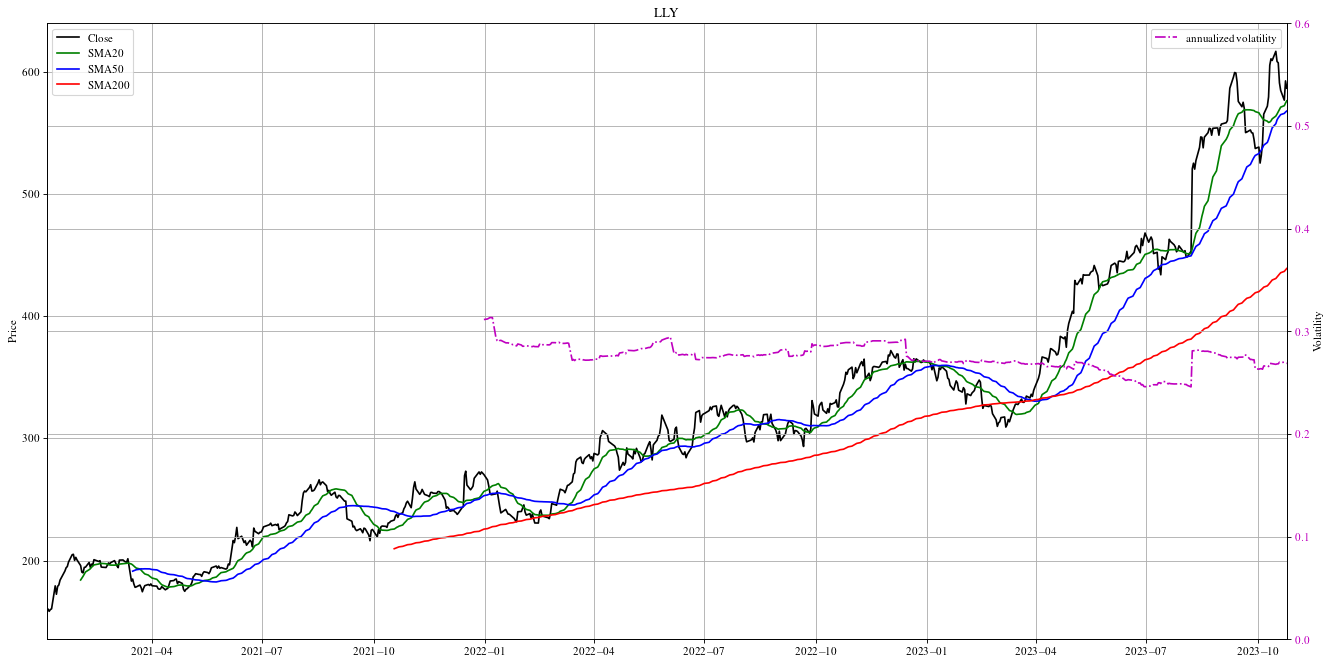

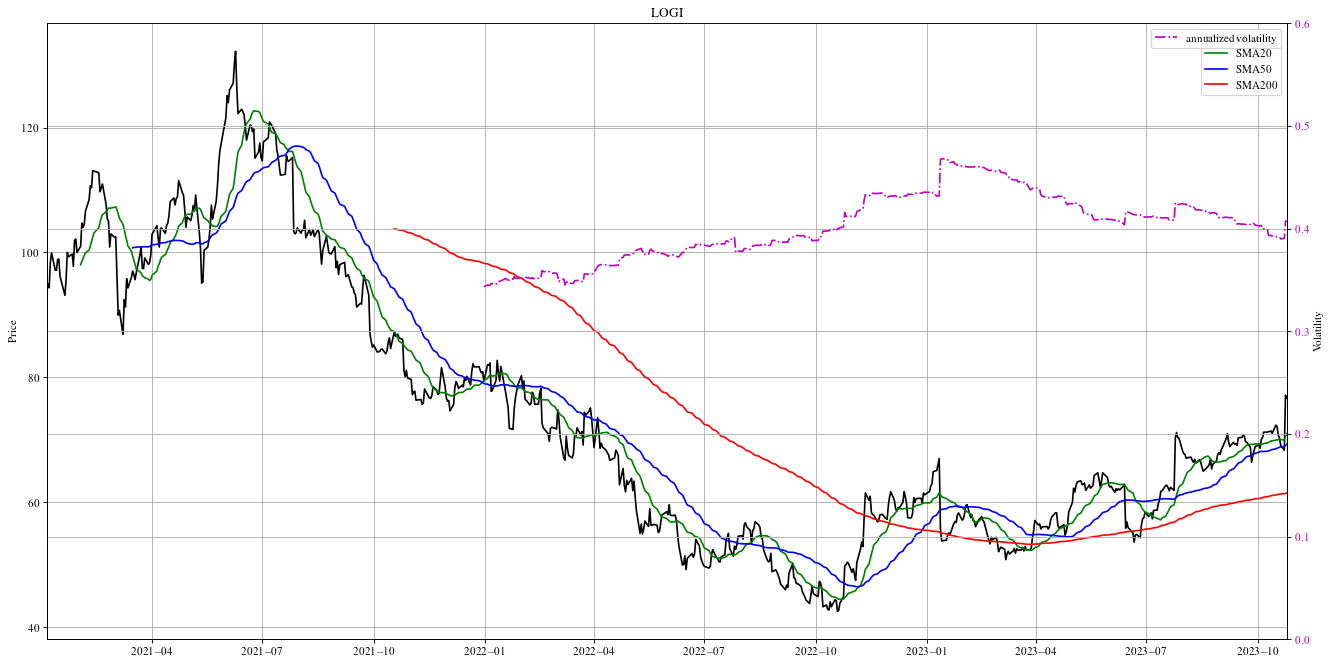

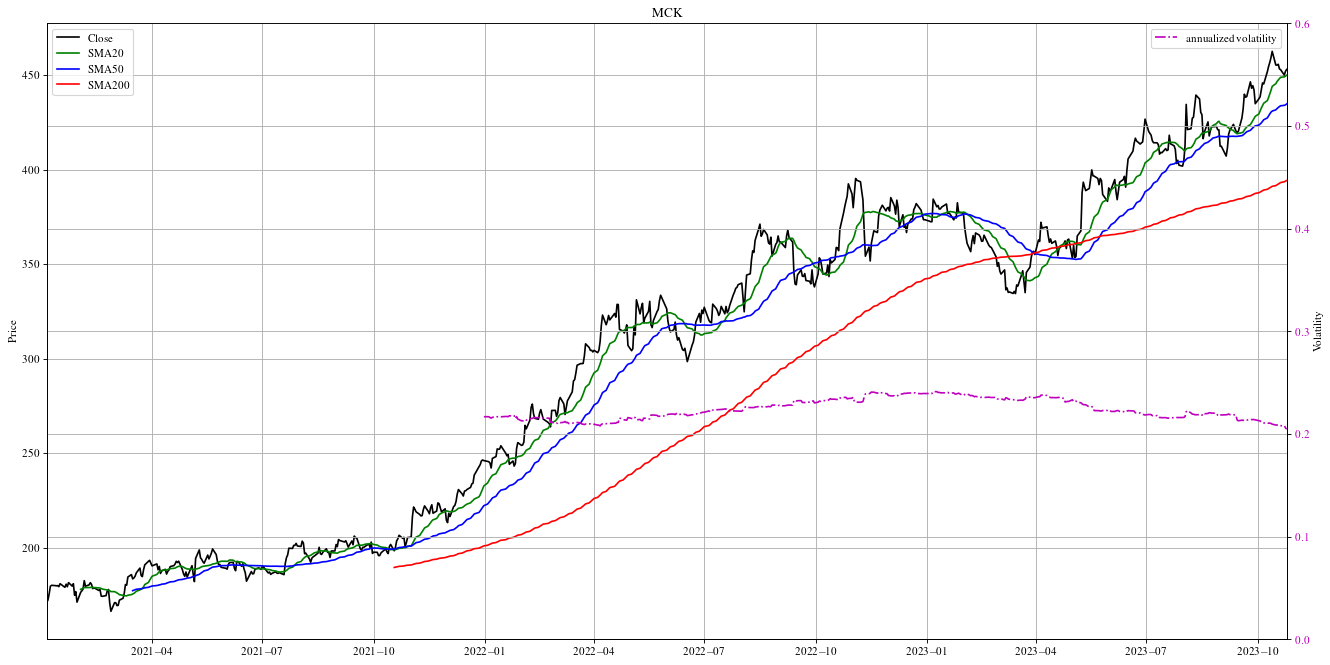

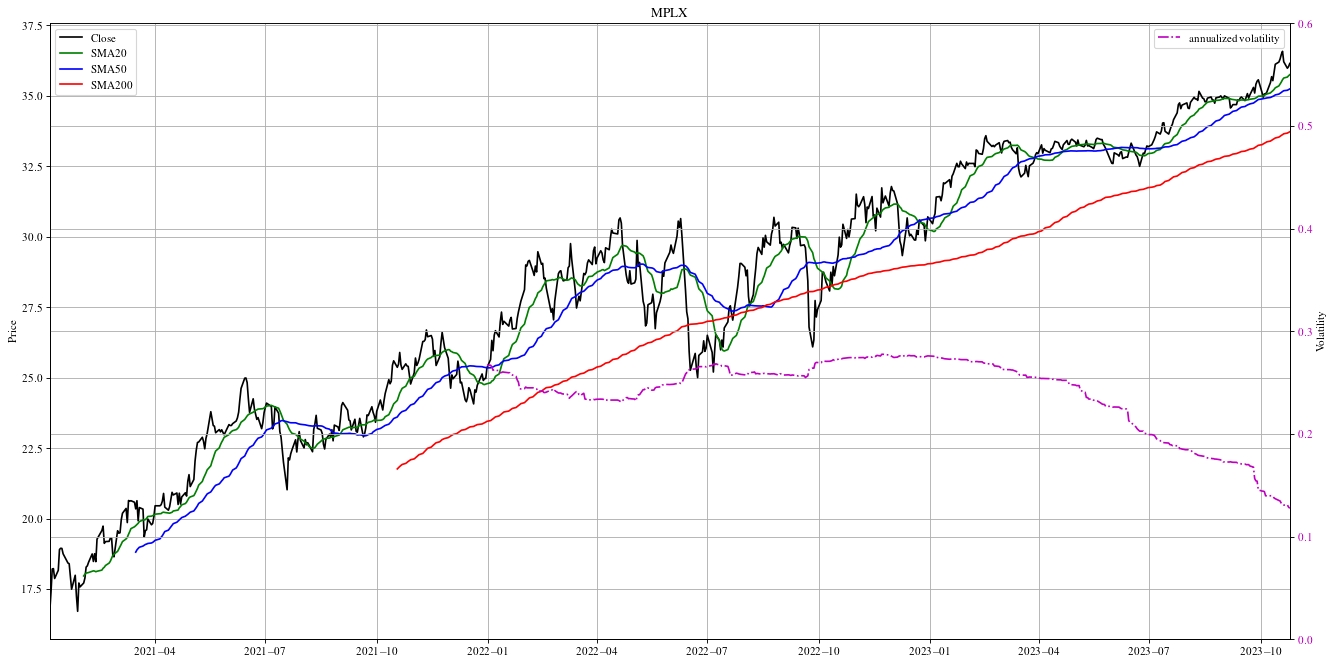

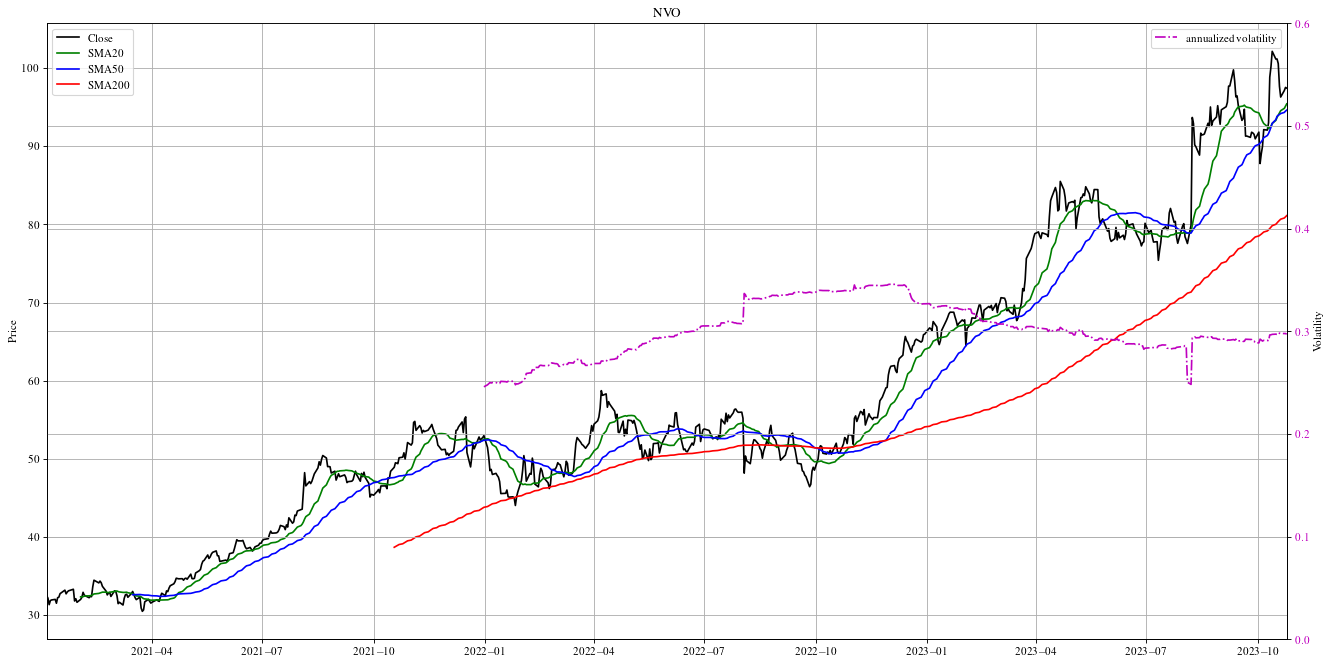

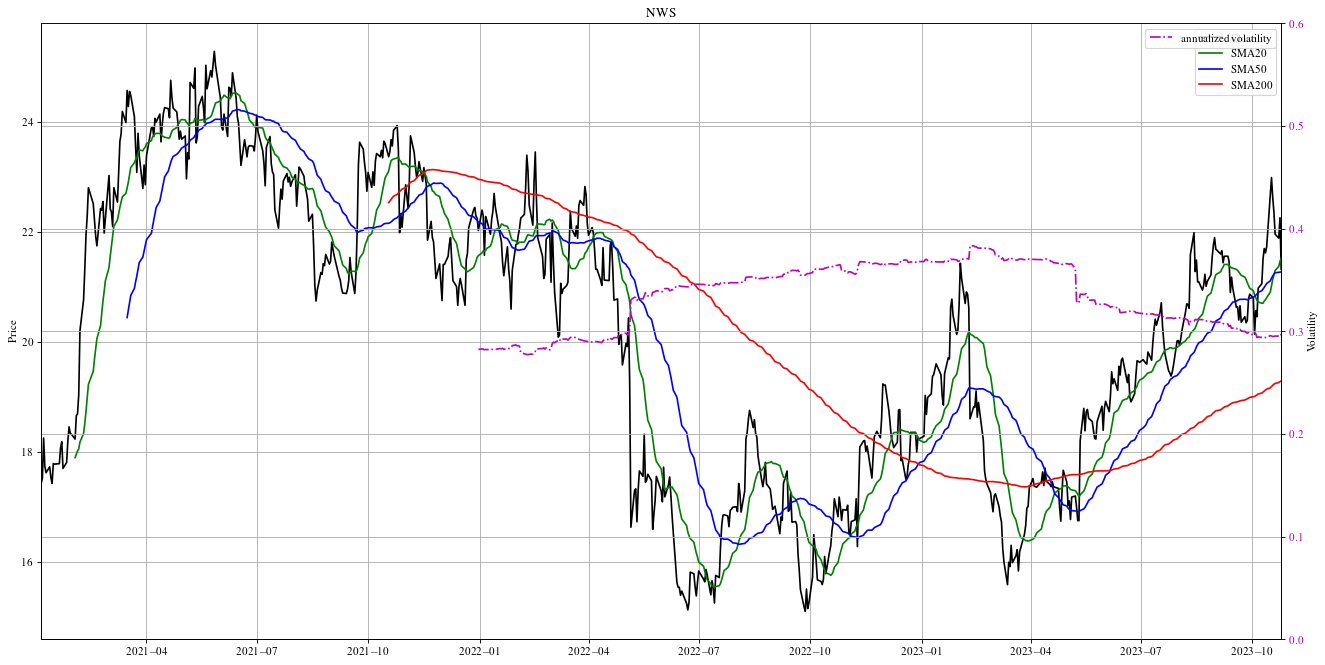

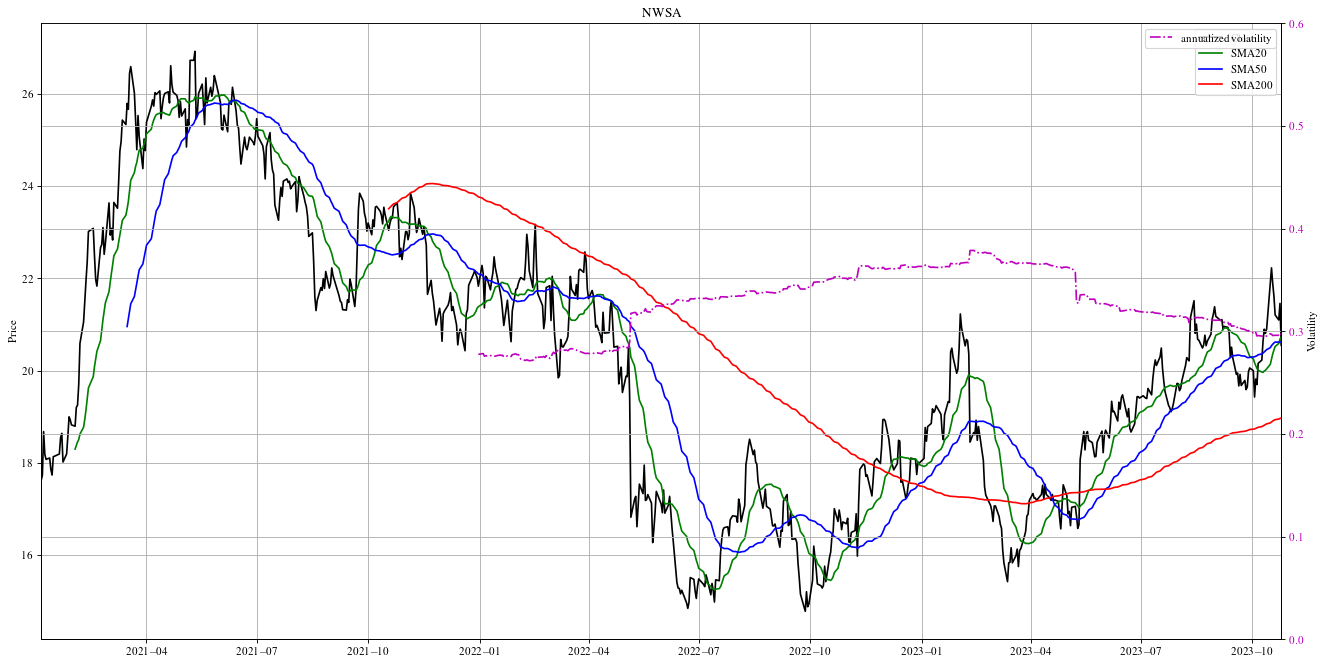

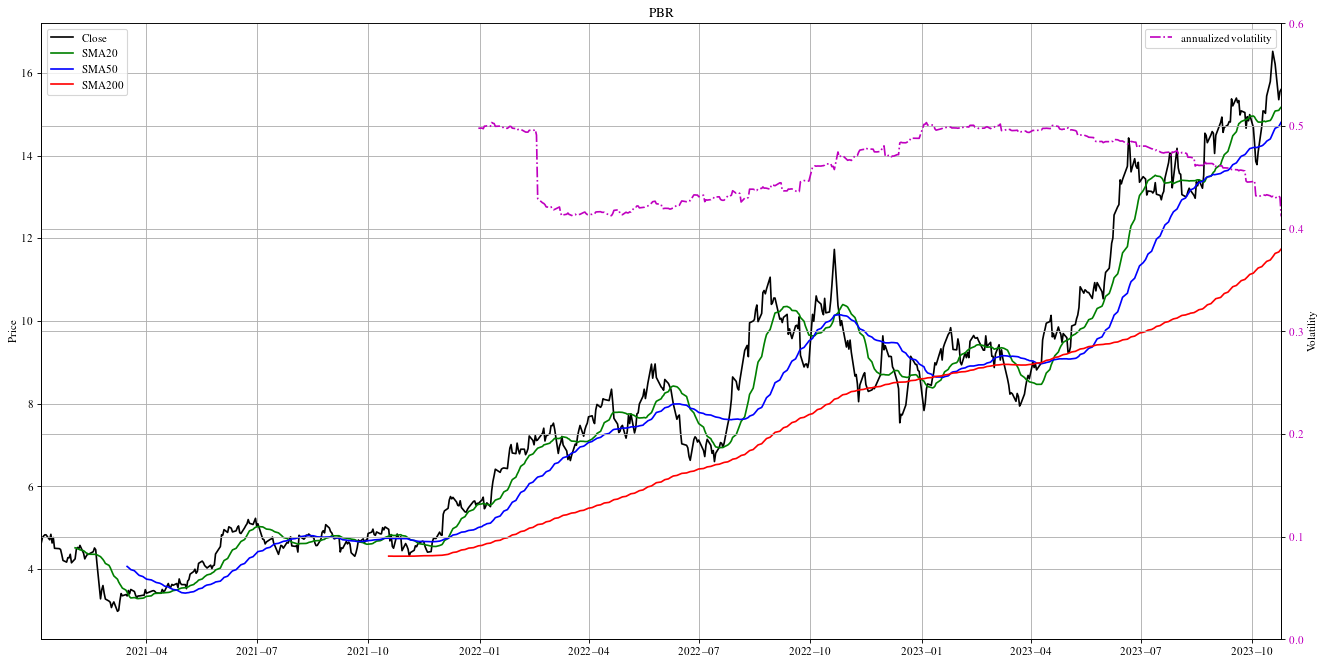

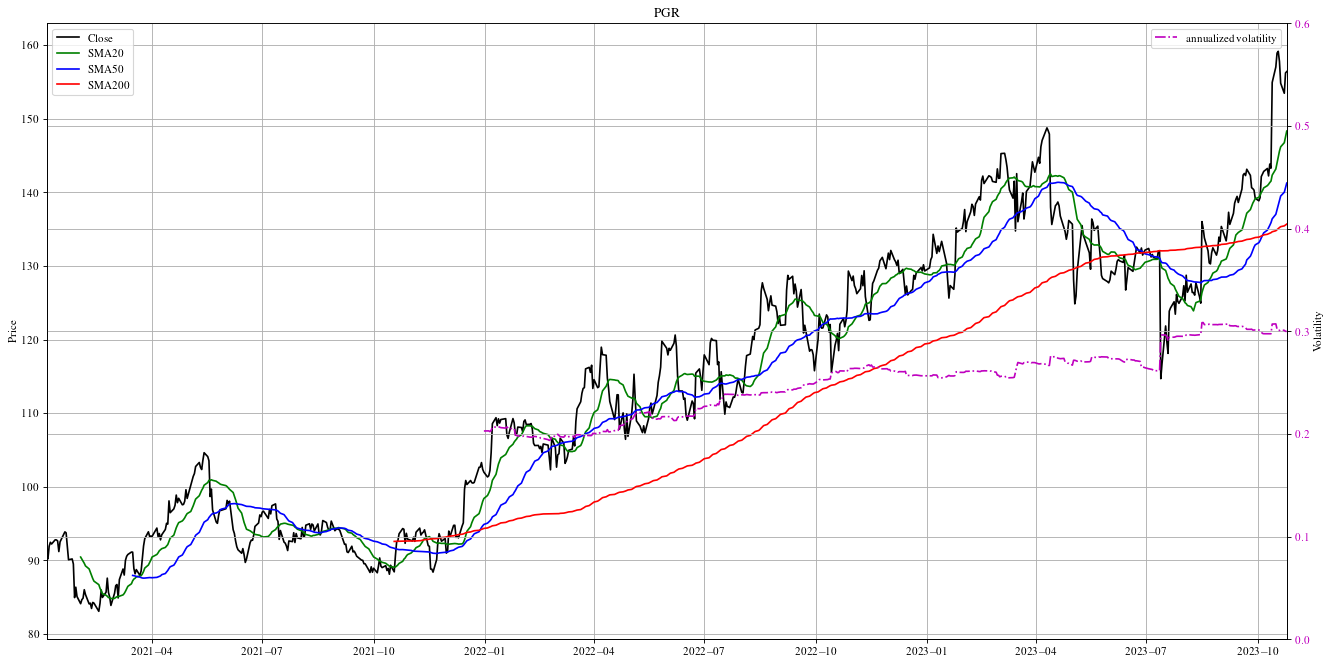

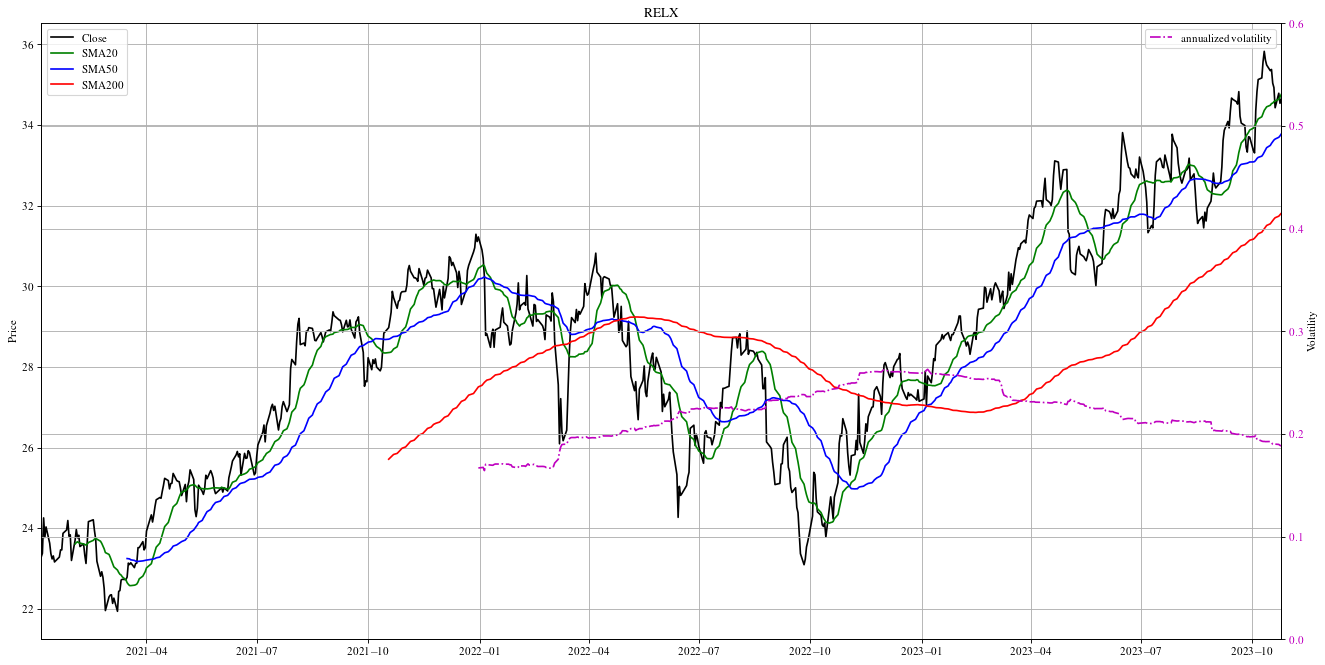

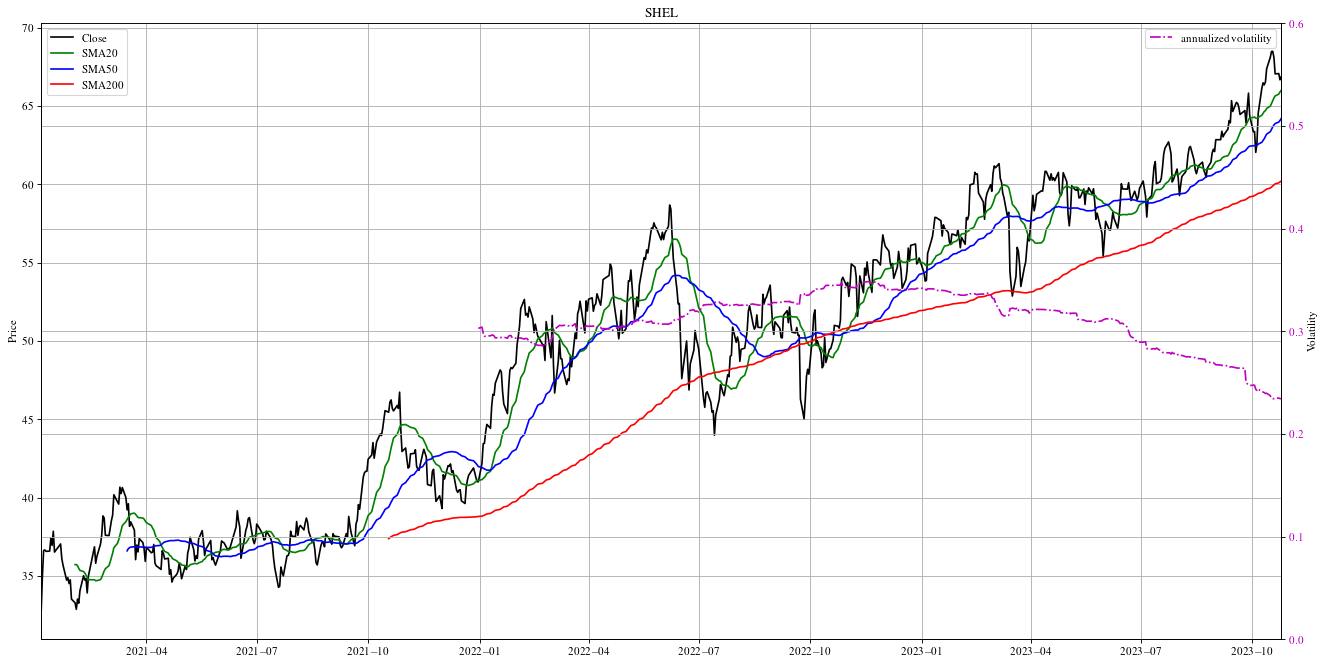

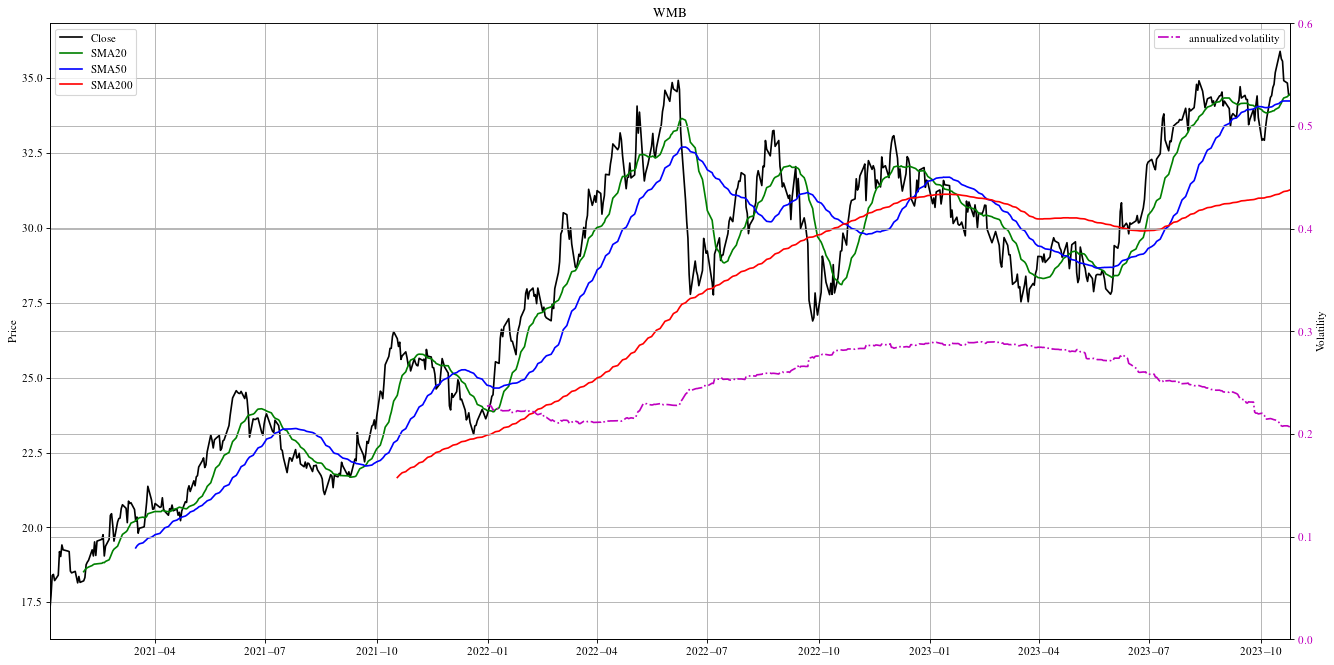

In [17]:
for ticker in tickers_list:

    info = data[ticker]
    
    if info['Close'][-1] > max_price and info['Close'][-1] < min_price:
        continue
    
    sma20 = info['Close'].rolling(window=20).mean()
    sma50 = info['Close'].rolling(window=50).mean()
    sma200 = info['Close'].rolling(window=200).mean()
    try:
        up12m=is_ticker_up(info, index_12m, index_now)
        up6m = is_ticker_up(info, index_6m, index_now)
        up3m = is_ticker_up(info, index_3m, index_now)
        up1m = is_ticker_up(info, index_1m, index_now)
        if up1m and up3m and up6m and up12m:
            
            # annualized volatility computation
            TRADING_DAYS = 252
            returns = np.log(info['Close']/info['Close'].shift(1))
            returns.fillna(0, inplace=True)
            volatility_1y = returns.rolling(
                window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)


            fig, ax_left = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=80,
                                facecolor='w', edgecolor='k')

            ax_left.plot(info['Close'], 'k', label='Close')
            ax_left.plot(sma20, 'g', label='SMA20')
            ax_left.plot(sma50, 'b', label='SMA50')
            ax_left.plot(sma200, 'r', label='SMA200')
            ax_left.set_title(ticker)
            ax_left.set_ylabel('Price')
            ax_left.set_xlim(info.index[0], info.index[-1])
            ax_left.grid()
            ax_left.legend()
            
            ax_right = ax_left.twinx()
            ax_right.plot(volatility_1y, 'm-.', label='annualized volatility')
            ax_right.set_xlabel('Date')
            ax_right.set_ylabel('Volatility')
            ax_right.set_xlim(info.index[0], info.index[-1])
            ax_right.set_ylim(0, .6)
            ax_right.grid()
            ax_right.tick_params(axis='y', labelcolor='m')
            ax_right.legend()
            plt.show()

    except:
        pass
